In [84]:
import sys, os 
import logging

import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch

#import tensorflow.keras.models.load_model
import pandas as pd


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext watermark
%watermark
print("\n")
print("tensorflow ",tf.__version__)
print("keras ",keras.__version__)
print("torch ",torch.__version__)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-10-07T20:57:37-07:00

CPython 3.7.4
IPython 7.17.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


tensorflow  2.1.0
keras  2.2.4-tf
torch  1.6.0


### Get Test Models

- pyTorch: vgg
- keras:  vgg
- huggingface: gpt_x
- other ?

In [2]:
# problem:  VERY OLD API

# load vgg model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

# load the model
vgg16_keras = VGG16()
vgg19_keras = VGG19()

# summarize the model
# model.summary()

#deprecated 
#from pytorchcv.model_provider import get_model as ptcv_get_model
#vgg16_pytorch = ptcv_get_model('vgg16', pretrained=True)
import torchvision
vgg16_pytorch = torchvision.models.vgg16(pretrained=True)
vgg16_pytorch_init = torchvision.models.vgg16()

### APIs

https://keras.io/api/layers/

In [3]:
from enum import IntFlag, auto, Enum

class LAYER_TYPE(IntFlag):
    UNKNOWN = auto()
    DENSE = auto()
    CONV1D = auto()
    CONV2D = auto()
    FLATTENED = auto()
    EMBEDDING = auto()
    NORM = auto()

    
class FRAMEWORK(IntFlag):
    UNKNOWN = auto()
    PYTORCH = auto()
    KERAS = auto()
    
class FRAMEWORK(IntFlag):
    UNKNOWN = auto()
    PYTORCH = auto()
    KERAS = auto()
    
class CHANNELS(IntFlag):
    FIRST = auto()
    LAST = auto()

## How can I extend / annotate the layer to add more elements

- base class -> child ?  ugh
- mixin
- wrapper class that is a class (I forget the pattern)

In [4]:
class WWLayer:
    """WW wrapper layer to Keras / PyTorch Layer object"""
    def __init__(self, layer, index=-1, name="", 
                 the_type=LAYER_TYPE.UNKNOWN, framework=FRAMEWORK.UNKNOWN, skipped=False):
        self.layer = layer
        self.index = index
        self.name = name
        self.skipped = skipped
        self.the_type = the_type
        self.framework = framework
        
        if (self.framework==FRAMEWORK.KERAS):
             self.channels = CHANNELS.FIRST
        elif (self.framework==FRAMEWORK.PYTORCH):
            self.channels = CHANNELS.LAST
        
        # orginal weights and biases
        self.has_weights = False
        self.weights = None
        
        self.has_biases = False
        self.biases = None
        
        # extracted weight matrices
        self.num_W = 0
        self.Wmats = []
        self.N = 0
        self.M = 0
        self.num_components = self.M
        self.receptive_field_size = 1
        self.inputs_shape = []
        self.outputs_shape = []
        
        # evals
        self.evals = None
        
        # details
        self.columns = []
        
        
    def add_column(self, name, value):
        """Add column to the details dataframe"""
        self.columns.append(name)
        self.__dict__[name] =  value
            
        
    def __repr__(self):
        return "WWLayer()"

    def __str__(self):
        return "WWLayer {}  {} {} {}  skipped {}".format(self.index, self.name, 
                                                       self.framework.name, self.the_type.name, self.skipped)
        
    
   

In [5]:
def model_iter(model):
    layer_iter = None
    
    if hasattr(model, 'layers'):
        layer_iter = (l for l in model.layers)
        framework = FRAMEWORK.KERAS
    elif hasattr(model, 'modules'):
        layer_iter = model.modules()
        framework = FRAMEWORK.PYTORCH
    else:
        layer_iter = None
        framework = FRAMEWORK.UNKNOWN
        
    return layer_iter, framework

In [6]:
def layer_weights(ww_layer):
    """obtain the orginal weights and biases for the layer, if present"""
    
    has_weights, has_biases = False, False
    weights, biases = None, None
    receptive_field_size = 1 # default for dense layer
    
    l = ww_layer.layer
      
    if ww_layer.framework==FRAMEWORK.PYTORCH:
        if hasattr(l, 'weight'):
            w = [np.array(l.weight.data.clone().cpu())]
            has_weights = True
            
    elif ww_layer.framework==FRAMEWORK.KERAS:
        w = l.get_weights()
        if(len(w)>0):
            has_weights = True
            
        if(len(w)>1):
            has_biases = True
            
        
    else:
        print("unknown framework")
        assert(False)
   
    if has_weights:
        if len(w)==1:
            weights = w[0]
            biases = None
        elif len(w)==2:
            weights = w[0]
            biases =  w[1]
        else:
            print("unknown weight shape")
            assert(False)
        
    
    #receptive_field_size = l.weight.data[0][0].numel()
    #            else:
    
    return has_weights, weights, has_biases, biases        

In [7]:
 
# TODO:  maybe change to use channels.first / channels.last 

def get_conv2D_Wmats(Wtensor):
        """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  
        Return ij (N x M) matrices
        
        """
        
        #self.info("get_conv2D_Wmats")

        Wmats = []
        s = Wtensor.shape
        N, M, imax, jmax = s[0],s[1],s[2],s[3]
        if N + M >= imax + jmax:
            #self.debug("Pytorch tensor shape detected: {}x{} (NxM), {}x{} (i,j)".format(N, M, imax, jmax))
            
            for i in range(imax):
                for j in range(jmax):
                    W = Wtensor[:,:,i,j]
                    if N < M:
                        W = W.T
                    Wmats.append(W)
        else:
            N, M, imax, jmax = imax, jmax, N, M          
            #self.debug("Tf.Keras.tensor shape detected: {}x{} (NxM), {}x{} (i,j)".format(N, M, imax, jmax))
            
            for i in range(imax):
                for j in range(jmax):
                    W = Wtensor[i,j,:,:]
                    if N < M:
                        W = W.T
                    Wmats.append(W)
                    
        #self.info("get_conv2D_Wmats N={} M={}".format(N,M))

        rf = imax*jmax # receptive field size 
        return Wmats, N, M, rf

In [8]:
def set_weight_matrices(ww_layer, conv2d_fft=False, conv2d_norm=True):
    """extract the weight matrices from the layer weights (tensors)
    sets the weights on the ww_layer
    
        conv2d_fft not supported yet """
    
    if not ww_layer.has_weights:
        # throw exception ?
        return 
        
    weights = ww_layer.weights
    the_type = ww_layer.the_type
    N, M, n_comp, rf = 0, 0, 0, None
    Wmats = []
    
    # this may change if we treat Conv1D differently layer
    if (the_type == LAYER_TYPE.DENSE or the_type == LAYER_TYPE.CONV1D):
        Wmats = [weights]
        N, M = np.max(weights.shape), np.min(weights.shape)
        n_comp = M
        
    elif the_type == LAYER_TYPE.CONV2D:
        Wmats, N, M, rf = get_conv2D_Wmats(weights)
        n_comp = M
        
    elif the_type == LAYER_TYPE.NORM:
        pass#print("Layer norm has no matrices")
    
    else:
        print("unknown type {} layer  {}".format(the_type, ww_layer.layer))


    ww_layer.N = N
    ww_layer.M = M
    ww_layer.num_components = n_comp
    ww_layer.receptive_field_size = rf
    ww_layer.Wmats = Wmats
    
    return 

In [9]:
def read_type_list(filename):
    """Read a list of layer types"""
    return None

In [10]:
def layer_type(layer):
    """Detemine layer type"""
    
    the_type = LAYER_TYPE.UNKNOWN
    typestr = (str(type(layer))).lower()
        
    # Keras TF 2.x types
    if isinstance(layer, tf.keras.layers.Dense): 
        the_type = LAYER_TYPE.DENSE
        
    elif isinstance(layer, keras.layers.Conv1D):                
        the_type = LAYER_TYPE.CONV1D
    
    elif isinstance(layer, keras.layers.Conv2D):                
        the_type = LAYER_TYPE.CONV2D
        
    elif isinstance(layer, tf.keras.layers.Flatten):
        the_type = LAYER_TYPE.FLATTENED
        
    elif isinstance(layer, tf.keras.layers.Embedding):
        the_type = LAYER_TYPE.EMBEDDING
        
    elif isinstance(layer, tf.keras.layers.LayerNormalization):
        the_type = LAYER_TYPE.NORM
        
        
 
    # PyTorch
    
         
    elif isinstance(layer, torch.nn.Linear):
        the_type = LAYER_TYPE.DENSE
        
    elif isinstance(layer, torch.nn.Conv1d):
        the_type = LAYER_TYPE.CONV1D

    elif isinstance(layer, torch.nn.Conv2d):
        the_type = LAYER_TYPE.CONV2D
        
    elif isinstance(layer, torch.nn.Embedding):
        the_type = LAYER_TYPE.EMBEDDING
            
    elif isinstance(layer, torch.nn.LayerNorm):
        the_type = LAYER_TYPE.NORM
        

    # try to infer type (i.e for huggingface)
    elif typestr.endswith(".linear'>"):
        the_type = LAYER_TYPE.DENSE
        
    elif typestr.endswith(".dense'>"):
        the_type = LAYER_TYPE.DENSE
        
    elif typestr.endswith(".conv1d'>"):
        the_type = LAYER_TYPE.CONV1D
        
    elif typestr.endswith(".conv2d'>"):
        the_type = LAYER_TYPE.CONV2D

    return the_type


In [11]:
def make_ww_layer(layer, index, filter_ids=None, filter_types=None, framework=None):
    """Make ww_layer or return None if layer is skipped"""
    
    skipped = False
    the_type = layer_type(layer)
    name = ""
    has_weights = False;
    
    if hasattr(layer, 'name'):
        name = layer.name
    
    if filter_ids is not None and len(filter_ids) > 0:
        if layer_id not in filter_ids:
            skipped = True
            
    if filter_types is not None and len(filter_types) > 0:
        if the_type not in filter_types:
            skipped = True
                                    
    
    ww_layer = WWLayer(layer, index=index, name=name, 
                 the_type=the_type, framework=framework, skipped=skipped)
    
    has_weights, weights, has_biases, biases = layer_weights(ww_layer)
    
    
    ww_layer.has_weights = has_weights
    ww_layer.has_biases = has_biases
    
    if has_biases:
        ww_layer.biases = biases   
        
    if has_weights:    
        ww_layer.weights = weights
        set_weight_matrices(ww_layer)

    
    return ww_layer

In [12]:
class WWLayerIterator:

    """Iterator that loops over layers, with matrices available."""

    def __init__(self, model, filter_ids=[], filter_types=[]):
        self.model = model
        self.layers_iter, self.framework = model_iter(model) 

        self.filter_ids = filter_ids
        self.filter_types = filter_types
        
        self.k = 0
        

    def __iter__(self):
        return self
    
    # Python 3 compatibility
    def __next__(self):
        return self.next()

    def next(self):
        curr_layer = next(self.layers_iter)
        if curr_layer:    
            curr_id, self.k = self.k, self.k+1
            #curr_layer = self.layers[curr_id]
            ww_layer = make_ww_layer(curr_layer, curr_id, 
                                     filter_ids=self.filter_ids, 
                                     filter_types=self.filter_types, 
                                     framework=self.framework)
                        
            return ww_layer
        else:
            raise StopIteration()

### Test with different frameworks



In [13]:
ww_layer_iterator = WWLayerIterator(vgg16_keras)

for ww_layer in ww_layer_iterator:
    print(ww_layer)
    for ww_layer in ww_layer_iterator:
    #    print(ww_layer)
        if(ww_layer.has_weights):
            print("W :",ww_layer.weights.shape)
        if(ww_layer.has_biases):
            print("b ",ww_layer.biases.shape)
        print(".......")

WWLayer 0  input_1 KERAS UNKNOWN  skipped False
W : (3, 3, 3, 64)
b  (64,)
.......
W : (3, 3, 64, 64)
b  (64,)
.......
.......
W : (3, 3, 64, 128)
b  (128,)
.......
W : (3, 3, 128, 128)
b  (128,)
.......
.......
W : (3, 3, 128, 256)
b  (256,)
.......
W : (3, 3, 256, 256)
b  (256,)
.......
W : (3, 3, 256, 256)
b  (256,)
.......
.......
W : (3, 3, 256, 512)
b  (512,)
.......
W : (3, 3, 512, 512)
b  (512,)
.......
W : (3, 3, 512, 512)
b  (512,)
.......
.......
W : (3, 3, 512, 512)
b  (512,)
.......
W : (3, 3, 512, 512)
b  (512,)
.......
W : (3, 3, 512, 512)
b  (512,)
.......
.......
.......
W : (25088, 4096)
b  (4096,)
.......
W : (4096, 4096)
b  (4096,)
.......
W : (4096, 1000)
b  (1000,)
.......


In [14]:
ww_layer_iterator = WWLayerIterator(vgg16_pytorch)

for ww_layer in ww_layer_iterator:
    print(ww_layer)
    for ww_layer in ww_layer_iterator:
    #    print(ww_layer)
        if(ww_layer.has_weights):
            print("W :",ww_layer.weights.shape)
        if(ww_layer.has_biases):
            print("b ",ww_layer.biases.shape)
        print(".......")


WWLayer 0   PYTORCH UNKNOWN  skipped False
.......
W : (64, 3, 3, 3)
.......
.......
W : (64, 64, 3, 3)
.......
.......
.......
W : (128, 64, 3, 3)
.......
.......
W : (128, 128, 3, 3)
.......
.......
.......
W : (256, 128, 3, 3)
.......
.......
W : (256, 256, 3, 3)
.......
.......
W : (256, 256, 3, 3)
.......
.......
.......
W : (512, 256, 3, 3)
.......
.......
W : (512, 512, 3, 3)
.......
.......
W : (512, 512, 3, 3)
.......
.......
.......
W : (512, 512, 3, 3)
.......
.......
W : (512, 512, 3, 3)
.......
.......
W : (512, 512, 3, 3)
.......
.......
.......
.......
.......
W : (4096, 25088)
.......
.......
.......
W : (4096, 4096)
.......
.......
.......
W : (1000, 4096)
.......


In [15]:
from transformers import  GPT2LMHeadModel
gpt2_lmh = GPT2LMHeadModel.from_pretrained('gpt2')

ww_layer_iterator = WWLayerIterator(gpt2_lmh)
for ww_layer in ww_layer_iterator:
#    print(ww_layer)
    if(ww_layer.has_weights):
        print("W :",ww_layer.weights.shape)
    if(ww_layer.has_biases):
        print("b ",ww_layer.biases.shape)
    print(".......")


.......
.......
unknown type 32 layer  Embedding(50257, 768)
W : (50257, 768)
.......
unknown type 32 layer  Embedding(1024, 768)
W : (1024, 768)
.......
.......
.......
.......
W : (768,)
.......
.......
W : (768, 2304)
.......
W : (768, 768)
.......
.......
.......
W : (768,)
.......
.......
W : (768, 3072)
.......
W : (3072, 768)
.......
.......
.......
W : (768,)
.......
.......
W : (768, 2304)
.......
W : (768, 768)
.......
.......
.......
W : (768,)
.......
.......
W : (768, 3072)
.......
W : (3072, 768)
.......
.......
.......
W : (768,)
.......
.......
W : (768, 2304)
.......
W : (768, 768)
.......
.......
.......
W : (768,)
.......
.......
W : (768, 3072)
.......
W : (3072, 768)
.......
.......
.......
W : (768,)
.......
.......
W : (768, 2304)
.......
W : (768, 768)
.......
.......
.......
W : (768,)
.......
.......
W : (768, 3072)
.......
W : (3072, 768)
.......
.......
.......
W : (768,)
.......
.......
W : (768, 2304)
.......
W : (768, 768)
.......
.......
.......
W : (768

In [16]:
layer_iterator = WWLayerIterator(vgg16_keras)

for ww_layer in layer_iterator:
    if(ww_layer.has_weights):
        print(ww_layer.weights.shape, ww_layer.biases.shape)

(3, 3, 3, 64) (64,)
(3, 3, 64, 64) (64,)
(3, 3, 64, 128) (128,)
(3, 3, 128, 128) (128,)
(3, 3, 128, 256) (256,)
(3, 3, 256, 256) (256,)
(3, 3, 256, 256) (256,)
(3, 3, 256, 512) (512,)
(3, 3, 512, 512) (512,)
(3, 3, 512, 512) (512,)
(3, 3, 512, 512) (512,)
(3, 3, 512, 512) (512,)
(3, 3, 512, 512) (512,)
(25088, 4096) (4096,)
(4096, 4096) (4096,)
(4096, 1000) (1000,)


### TODO

- set a few basics for keras and tf, then infer the rest by name
- allow a yaml that people can edit with lists of others



- set rf, M, N
- set orig tensor ?
- be able to reset weights => layer iterator allows get and set
- try to get inputs , outputs for both frameworks
- test attention model => need to label properly the attention layer matrices
- extract combined eigenvalues for Conv2D
- extract matrices for attention
- RNN, LSTM, ... (pretrained from where)
- be able to take W-Wdiff using original tensor, not slices

## TODO:  Wednesday++

- write wwcomparator: use iterator to compare |W-Winit|
- write wwregularizer:  use iterator to compute SVD, output new model
- rewrite ww:  compute SVD, ESD, supporting metrics, etc

#### Python Lint s
- clean nup documentation 

In [17]:
# not used

def same_models(model_1, model_2):
    """Compare models to see if the are the same architecture"""
    
    same = True
    layer_iter_1 = WWLayerIterator(model_1)
    layer_iter_2 = WWLayerIterator(model_2)
    
    same = layer_iter_1.framework == layer_iter_2.framework 

  
    return same

In [18]:
def distances(model_1, model_2):
    """Compute the distances between model_1 and model_2 for each layer. 
    Reports Frobenius norm of the distance between each layer weights (tensor)
    
       < ||W_1-W_2|| >
       
    output: avg delta W, a details dataframe
       
    models should be the same size and from the same framework
       
    """
    
    # check and throw exception if inputs incorrect
    # TODO: review design here...may need something else
    #   need to:
    #.   - iterate over all layers and check
    #.   - inspect framework by framework
    #.   - check here instead
    #
    
    same = True
    layer_iter_1 = WWLayerIterator(model_1)
    layer_iter_2 = WWLayerIterator(model_2)
    
    same = layer_iter_1.framework == layer_iter_2.framework 
    if not same:
        raise Exception("Sorry, models are from different frameworks")
        
   
    
    details = pd.DataFrame(columns = ['layer_id', 'name', 'delta_W', 'delta_b', 'W_shape', 'b_shape'])
    data = {}
    
    try:      
        for layer_1, layer_2 in zip(layer_iter_1, layer_iter_2):
            data['layer_id'] = layer_1.index
            data['name'] = layer_1.name

            if layer_1.has_weights:
                data['delta_W'] = np.linalg.norm(layer_1.weights-layer_2.weights)
                data['W_shape'] = layer_1.weights.shape

                if layer_1.has_biases:
                    data['delta_b'] = np.linalg.norm(layer_1.biases-layer_2.biases)
                    data['b_shape'] = layer_1.biases.shape

                details = details.append(data,  ignore_index=True)
    except:
        raise Exception("Sorry, problem comparing models")
    
    details.set_index('layer_id', inplace=True)
    avg_dW = np.mean(details['delta_W'].to_numpy())
    return avg_dW, details

In [19]:
avg_dW, details = distances(vgg16_keras, vgg16_keras)
details

,name,delta_W,delta_b,W_shape,b_shape
layer_id,,,,,
1,block1_conv1,0.0,0.0,"(3, 3, 3, 64)","(64,)"
2,block1_conv2,0.0,0.0,"(3, 3, 64, 64)","(64,)"
4,block2_conv1,0.0,0.0,"(3, 3, 64, 128)","(128,)"
5,block2_conv2,0.0,0.0,"(3, 3, 128, 128)","(128,)"
7,block3_conv1,0.0,0.0,"(3, 3, 128, 256)","(256,)"
8,block3_conv2,0.0,0.0,"(3, 3, 256, 256)","(256,)"
9,block3_conv3,0.0,0.0,"(3, 3, 256, 256)","(256,)"
11,block4_conv1,0.0,0.0,"(3, 3, 256, 512)","(512,)"
12,block4_conv2,0.0,0.0,"(3, 3, 512, 512)","(512,)"


In [20]:
avg_dW, details = distances(vgg16_pytorch, vgg16_pytorch_init)
details

,name,delta_W,delta_b,W_shape,b_shape
layer_id,,,,,
2,,10.790011,NaN,"(64, 3, 3, 3)",NaN
4,,15.694499,NaN,"(64, 64, 3, 3)",NaN
7,,17.584372,NaN,"(128, 64, 3, 3)",NaN
9,,21.841988,NaN,"(128, 128, 3, 3)",NaN
12,,23.593069,NaN,"(256, 128, 3, 3)",NaN
14,,29.470362,NaN,"(256, 256, 3, 3)",NaN
16,,29.912214,NaN,"(256, 256, 3, 3)",NaN
19,,32.590324,NaN,"(512, 256, 3, 3)",NaN
21,,40.711391,NaN,"(512, 512, 3, 3)",NaN


### Decorator

https://www.programiz.com/python-programming/decorator

make_ww_layer()

Can I decorate an iterator ?

Or just make another iterator

- WWLayerSVDIterator
- WWLayerESDIterator

thats fine

what about classes / objects ?



In [21]:
class Foo:
    def __init__(self):
        # we can dynamically have access to the properties dict using __dict__
        self.__dict__['x'] = 'bar'
        self.columns = []
    
    def add_column(self, name, value):
        self.columns.append(name)
        self.__dict__[name] =  value


In [22]:
foo = Foo()
foo.add_column("y", 3.4)

In [23]:
print(foo.y)


3.4


### SVD and ESD methods

#### How to treat ?
 - analyze parameters:  min size, max_size  ?
 
 params = {} 
 
 - use monkey patching to store new values s
 -  also store new names so we 
  -   know what was added
  -   can extract later for the detaild dataframe
  
  

In [68]:
# make this a static method ?        
def combined_eigenvalues( weights, N, M, n_comp, params):
    """Compute the eigenvalues for all weights of the NxM weight matrices (N >= M), 
        combined into a single, sorted, numpy array

        Applied normalization and glorot_fix if specified

        Assumes an array of weights comes from a conv2D layer and applies conv2d_norm normalization by default

        Also returns max singular value and rank_loss, needed for other calculations
     """

    all_evals = []
    max_sv = 0.0
    rank_loss = 0

    normalize =params['normalize']
    glorot_fix =params['glorot_fix']
    conv2d_norm =params['conv2d_norm']


    count = len(weights)
    for  W in weights:

        Q=N/M
        #check, checkTF = glorot_norm_check(W, N, M, count) 

        # assume receptive field size is count
        if glorot_fix:
            W = glorot_norm_fix(W, N, M, count)
        elif conv2d_norm:
            # probably never needed since we always fix for glorot
            W = W * np.sqrt(count/2.0) 

        # SVD can be swapped out here
        # svd = TruncatedSVD(n_components=M-1, n_iter=7, random_state=10)

        W = W.astype(float)
        #self.debug("Running full SVD:  W.shape={}  n_comp = {}".format(W.shape, n_comp))
        sv = np.linalg.svd(W, compute_uv=False)
        sv = sv.flatten()
        sv = np.sort(sv)[-n_comp:]
        #if len(sv) > max_size:
        #    #self.info("chosing {} singular values from {} ".format(max_size, len(sv)))
        #    sv = np.random.choice(sv, size=max_size)

        #sv = svd.singular_values_
        evals = sv*sv
        if normalize:
            evals = evals/N

        all_evals.extend(evals)

        max_sv = np.max([max_sv, np.max(sv)])
        max_ev = np.max(evals)
        rank_loss = 0#rank_loss + self.calc_rank_loss(sv, M, max_ev)

    return np.sort(np.array(all_evals)), max_sv, rank_loss

In [75]:
def debug(msg):
    print(msg)
    

          
def apply_esd(layer, params={}):
    """run full SVD on layer weight matrices, compute ESD, combine all,  and save to layer """
    
    layer_id = layer.index
    name = layer.name
    the_type = layer.the_type
     
    M  = layer.M
    N  = layer.N
    rf = 1.0#layer.receptive_field_size
    
    min_size = params['min_size']
    max_size = params['max_size']
    
 
    if not layer.has_weights:
        debug("Layer {} {} has no weights".format(layer_id, name))
    
    elif the_type is LAYER_TYPE.UNKNOWN:
        debug("Layer {} {} type {} unknown".format(layer_id, name, the_type))
    
    elif the_type in [LAYER_TYPE.FLATTENED, LAYER_TYPE.NORM]:
        debug("Layer {} {} type {} not supported".format(layer_id, name, the_type))
    
    elif  M*rf < min_size:
        debug("Layer {} {}: size {} < {}".format(layer_id, name, M*rf, min_size))
              
    elif  N > max_size:
        debug("Layer {} {}: size {} > {}".format(layer_id, name, N, max_size))
    
    elif the_type  in [LAYER_TYPE.DENSE, LAYER_TYPE.CONV1D, LAYER_TYPE.CONV2D]:
        Wmats = layer.Wmats
        n_comp = layer.num_components
        
        params = {}
        # can skip min_size, max_size directly here if we want to
        params['normalize'] = True
        params['glorot_fix'] = False
        params['conv2d_norm'] = True
        
        evals, sv_max, rank_loss = combined_eigenvalues(Wmats, N, M, n_comp, params)
     
        layer.evals = evals
        layer.add_column("has_esd",True)
        layer.add_column("num_evals",len(evals))
        layer.add_column("sv_max",sv_max)
        layer.add_column("rank_loss",rank_loss)
        layer.add_column("lambda_max",np.max(evals))
        
    return layer
              

In [92]:
def apply_plot_esd(layer, params={}):
    evals = ww_layer.evals
    name = ww_layer.name
    plt.title(name)
    plt.hist(np.log10(evals), bins=100)
    plt.show()
    return layer

In [93]:
def apply_power_law_fit(layer, params={}):
    # check that ESD has been computed
    
    # how render the plots
    return layer

In [94]:
def apply_marchenko_pastur_fit(layer, params={}):
    
    return layer

In [95]:
def apply_smooth_model(layer, params={}):
    
    return layer

In [96]:
def get_details(layer_iterator):
    df = pd.DataFrame()
    
    return df

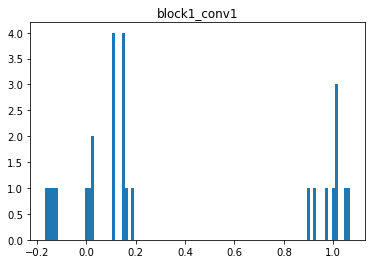

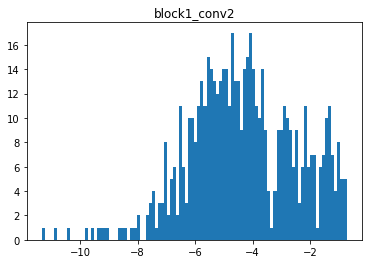

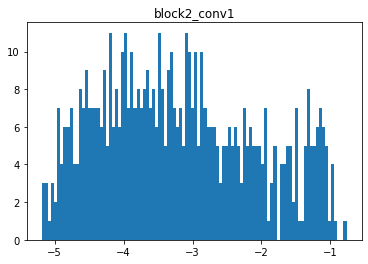

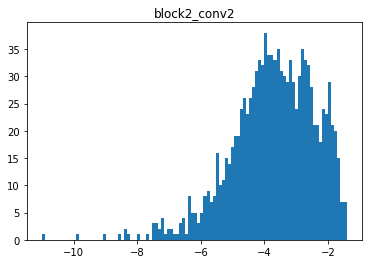

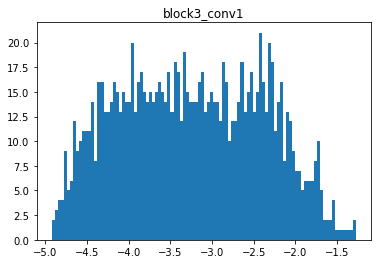

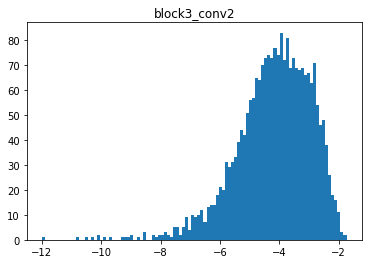

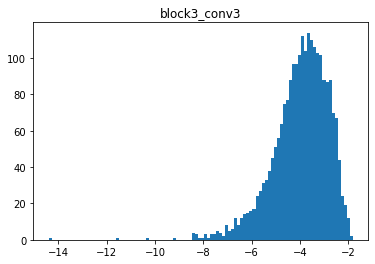

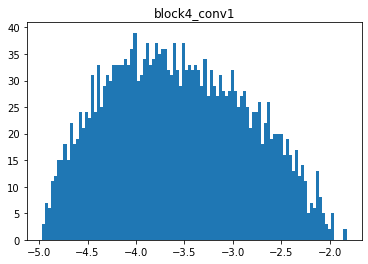

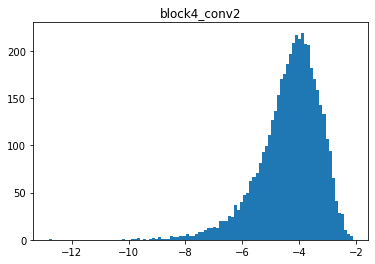

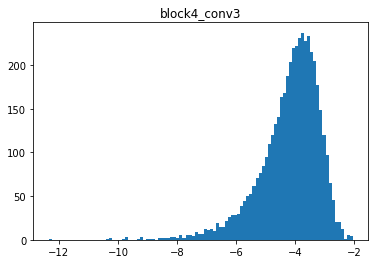

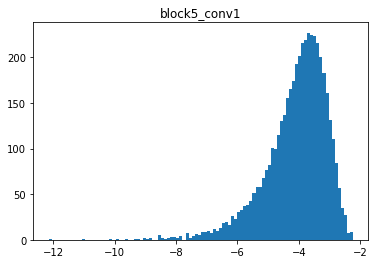

In [ ]:
layer_iterator = WWLayerIterator(vgg16_keras)

params = {}
params['min_size']=0
params['max_size']=100000

for ww_layer in layer_iterator:
    if(ww_layer.has_weights):
        apply_esd(ww_layer, params)
        apply_plot_esd(ww_layer, params)

### fix receptive field size


In [82]:
for ww_layer in layer_iterator:
    print(ww_layer.has_esd)